# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [50]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_simNy import sim1d



from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import seaborn as sns


### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




The number of runs are large so a fractional factorial design is adopted.

## Fractional Factorial Design

In [51]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 11
design2 = fracfact('a b c d e f g h abcd abce abde')
L_level = 0.99
R_level = 1.01
perc_change = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.8, 0.03, 0.60, 0.30,0.30]
factor_levels = {
    'rho_l': [2460.0, 2460.0 * (1 + perc_change[0])],
    'rho_s': [2710.0, 2710.0 * (1 + perc_change[1])],
    'k_l': [104.0, 104.0 * (1 + perc_change[2])],
    'k_s': [96.2,  96.2* (1 + perc_change[3])],
    'cp_l': [1245.3, 1245.3* (1 + perc_change[4])],
    'cp_s': [963.0, 963.0 * (1 + perc_change[5])],
    'Surr_temp': [313.0, 313.0 * (1 + perc_change[6])],
    'L_fusion': [389e3, 389e3 * (1 + perc_change[7])],
    'temp_init': [880.0, 880.0 * (1 + perc_change[8])],
    'heat_transfer_coefficient_left': [10.0, 10.0 * (1 + perc_change[9])],
    'heat_transfer_coefficient_right': [11.0, 10.0 * (1 + perc_change[10])],
}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)
akon =0
for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(256, 11)


In [3]:
FracFact_doe_sol_time = doe_df_sol_time_fracfact.copy()

FracFact_doe_sol_time['Lowest_Niyama'] = [0.0] * FracFact_doe_sol_time.shape[0] # Data frame inclduing the response variable

# print(Res_doe_sol_time.head(5))



In [4]:
# here the response values are calculated using sim1d function

for i in range(FracFact_doe_sol_time.shape[0]):
    input_values = FracFact_doe_sol_time.iloc[i,:-1].values
    k= sim1d(*input_values)
    FracFact_doe_sol_time.at[i, 'Lowest_Niyama'] = k
    

    

Lowest Niyama:4.53, rho_l:2460.0, rho_s:2710.0, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:1408.0,htc_l:13.0,htc_r:13.0
Lowest Niyama:0.0, rho_l:2533.8, rho_s:2710.0, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:880.0,htc_l:10.0,htc_r:11.0
Lowest Niyama:0.0, rho_l:2460.0, rho_s:2791.3, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:880.0,htc_l:10.0,htc_r:11.0
Lowest Niyama:4.64, rho_l:2533.8, rho_s:2791.3, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:1408.0,htc_l:13.0,htc_r:13.0
Lowest Niyama:2.09, rho_l:2460.0, rho_s:2710.0, k_l:107.12, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:880.0,htc_l:10.0,htc_r:13.0
Lowest Niyama:0.94, rho_l:2533.8, rho_s:2710.0, k_l:107.12, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:1408.0,htc_l:13.0,htc_r:11.0
Lowest 

### Histogram of the Total Solidifcation time is plotted

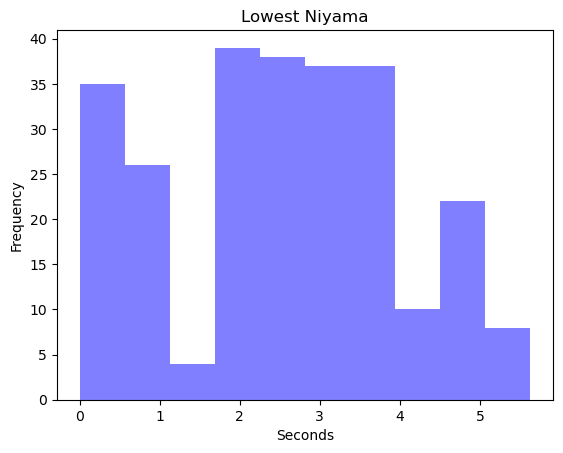

In [5]:
plt.hist(FracFact_doe_sol_time['Lowest_Niyama'], bins=10, alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

### Regression model is developed

In [16]:


# Create the formula for the ANOVA
formula = 'Lowest_Niyama ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient_left)+C(heat_transfer_coefficient_right)'

# Fit the model
model = sm.OLS.from_formula(formula, data=FracFact_doe_sol_time).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     41.66
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           7.54e-50
Time:                        16:57:28   Log-Likelihood:                -328.14
No. Observations:                 256   AIC:                             680.3
Df Residuals:                     244   BIC:                             722.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Plot of Residuals

The plots of the residuals vs. fitted values are shown below


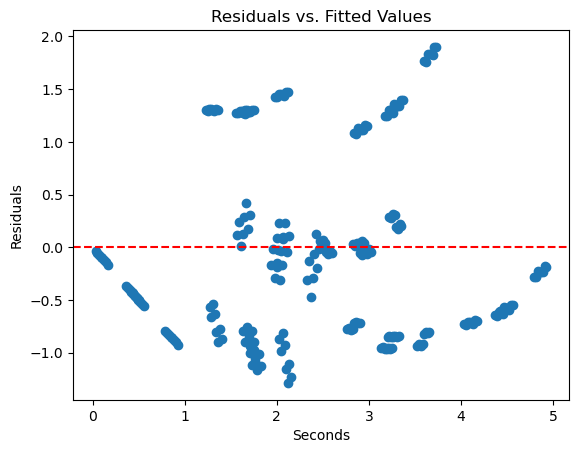

In [17]:
residuals_ols = model.resid
FracFact_doe_sol_time['Residuals'] =residuals_ols
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Seconds')
plt.ylabel('Residuals')
plt.show()


# print (f"This is followed by the histogram of the residuals")
# plt.hist(residuals_ols, bins=10, alpha=0.5, color='b')
# plt.title('Residuals Histogram')
# plt.xlabel('Seconds')
# plt.ylabel('Frequency')
# plt.show()

### Normality of Residuals check

In [18]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


Shapiro-Wilk Test Statistic: 0.881534325100953
p-value: 3.1571414598268037e-13
The residuals are not normally distributed (reject H0).


In [19]:
from statsmodels.formula.api import ols
# Create the formula for the ANOVA
formula = 'Lowest_Niyama ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp)+ C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient_left)+C(heat_transfer_coefficient_right)'

# Fit the model
model_anova = ols(formula, data=FracFact_doe_sol_time).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model_anova, typ=2)

# Display the ANOVA results
print(anova_results)
print(model.summary())

                                        sum_sq     df           F  \
C(rho_l)                             10.660225    1.0   13.367402   
C(rho_s)                              7.812025    1.0    9.795898   
C(k_l)                                0.000056    1.0    0.000071   
C(k_s)                                0.319225    1.0    0.400293   
C(cp_l)                               0.000156    1.0    0.000196   
C(cp_s)                               0.027225    1.0    0.034139   
C(Surr_temp)                         91.345806    1.0  114.543183   
C(L_fusion)                           0.108900    1.0    0.136555   
C(temp_init)                          0.017889    1.0    0.022432   
C(heat_transfer_coefficient_left)   100.425452    1.0  125.928615   
C(heat_transfer_coefficient_right)  154.722502    1.0  194.014466   
Residual                            194.584925  244.0         NaN   

                                          PR(>F)  
C(rho_l)                            3.135667e-04  


### Main Effects 

Critical F-value: 3.8798520003132926


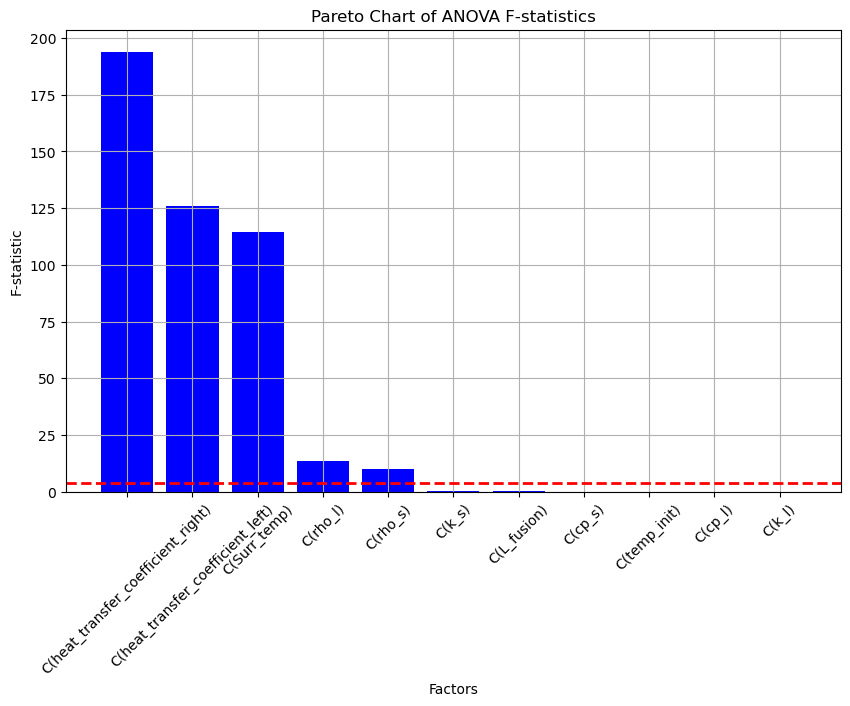

In [10]:
from scipy.stats import f
# Create a DataFrame from the ANOVA results
anova_results_df = anova_results.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df = anova_results_df.sort_values(by='F', ascending=False)

dfn = anova_results_df['df'][0]
dfd = model.df_resid

alpha = 0.05
f_critical = f.ppf(1-alpha, dfn, dfd)
print(f'Critical F-value: {f_critical}')

# Plot the Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(anova_results_df['index'], anova_results_df['F'], color='b')
plt.axhline(f_critical, color='r', linestyle='--',linewidth=2)
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Main effects and Interactions Terms Analysis

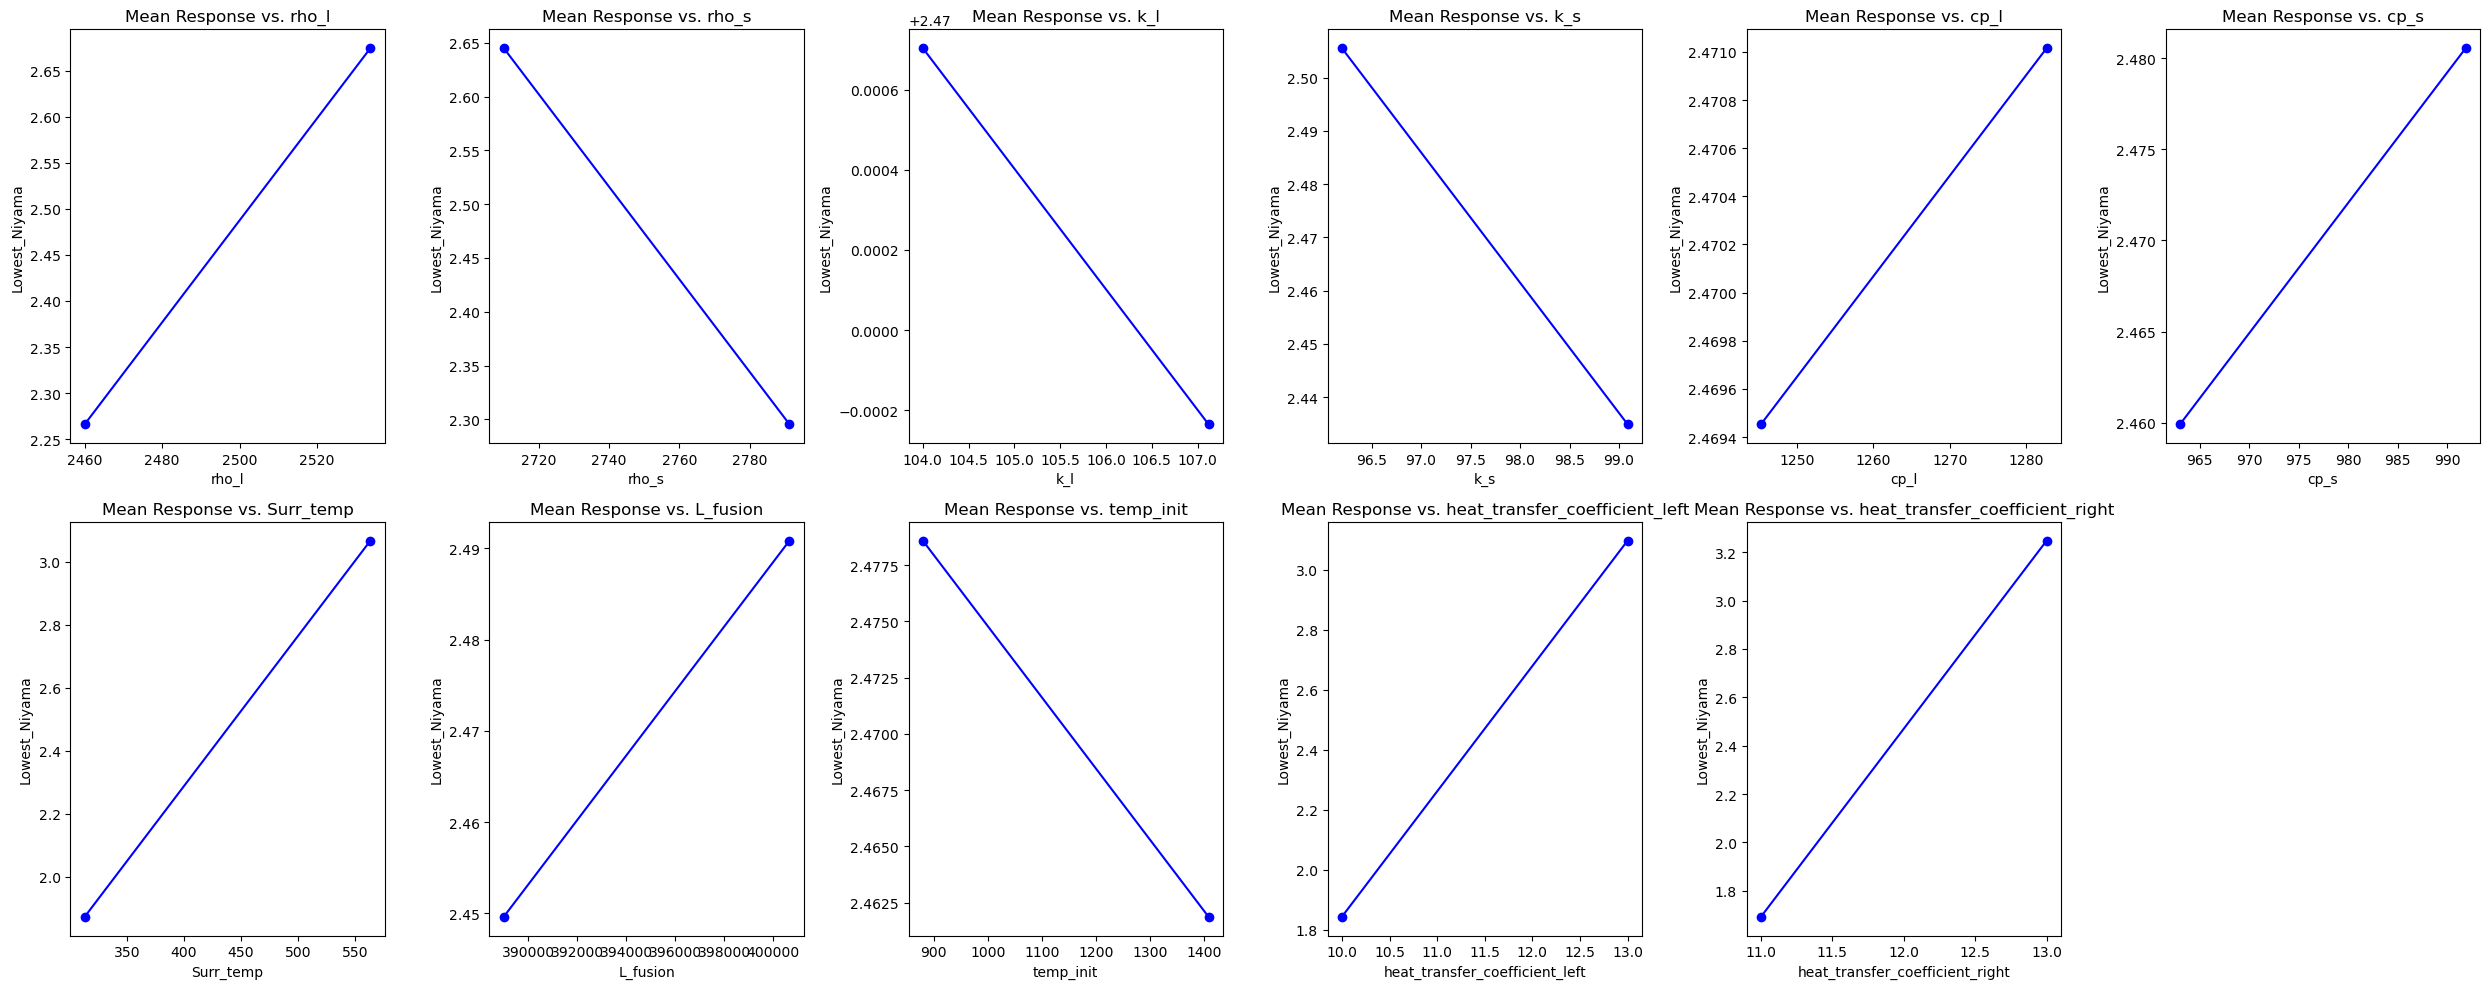

In [11]:
mean_response = {}

for factor in factor_names:
    mean_response[factor] = FracFact_doe_sol_time.groupby(factor)['Lowest_Niyama'].mean()

plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 6, i+1)
    plt.plot(mean_response[factor], marker='o', color='b')
    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Lowest_Niyama')

plt.tight_layout()
plt.show()


In [12]:
# # Function to plot interaction effects
# def plot_interaction(df, factor1, factor2, response):
#     levels1 = sorted(df[factor1].unique())
#     levels2 = sorted(df[factor2].unique())
    
#     mean_responses = df.groupby([factor1, factor2])[response].mean().unstack()
    
#     plt.figure()
#     for level2 in levels2:
        
#         plt.plot(levels1, mean_responses[level2], marker='o', label=f'{factor2}={level2}')
#     plt.xlabel(factor1)
#     plt.ylabel(f'Mean {response}')
#     plt.title(f'Interaction Effect of {factor1} and {factor2}')
#     plt.legend()
#     plt.show()

# # Plot interaction effects for each pair of factors
# plt.figure(figsize=(10, 6))

# for i in range(len(factor_names)):
    
#     for j in range(i+1, len(factor_names)):
        
#         plot_interaction(FracFact_doe_sol_time, factor_names[i], factor_names[j], 'total_sol_time')
# plt.tight_layout()
# plt.show()

The interaction was observed among rho_l and cp_s , rho_s and cp_s , cp_l and cp_s  & cp_s and temp_init.

## Center points check

In [53]:
num_center_points = 1

center_point = {factor: np.mean(levels) for factor,levels in factor_levels.items()}

center_pt_df = pd.DataFrame([center_point] * num_center_points, columns=factor_names)

doe_center_pt = pd.concat([doe_df_sol_time_fracfact, center_pt_df], ignore_index=True)
# print(doe_center_pt.tail(5))

### Factorial design

In [14]:
Fractional_Factorial_doe_center_pt = doe_center_pt.copy()

Fractional_Factorial_doe_center_pt['Lowest_Niyama'] = [0.0] * Fractional_Factorial_doe_center_pt.shape[0]


In [20]:
for i in range(Fractional_Factorial_doe_center_pt.shape[0]):
    input_values = Fractional_Factorial_doe_center_pt.iloc[i,:-1].values
    k= sim1d(*input_values)
    Fractional_Factorial_doe_center_pt.at[i, 'Lowest_Niyama'] = k

Lowest Niyama:4.53, rho_l:2460.0, rho_s:2710.0, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:1408.0,htc_l:13.0,htc_r:13.0
Lowest Niyama:0.0, rho_l:2533.8, rho_s:2710.0, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:880.0,htc_l:10.0,htc_r:11.0
Lowest Niyama:0.0, rho_l:2460.0, rho_s:2791.3, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:880.0,htc_l:10.0,htc_r:11.0
Lowest Niyama:4.64, rho_l:2533.8, rho_s:2791.3, k_l:104.0, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:1408.0,htc_l:13.0,htc_r:13.0
Lowest Niyama:2.09, rho_l:2460.0, rho_s:2710.0, k_l:107.12, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:880.0,htc_l:10.0,htc_r:13.0
Lowest Niyama:0.94, rho_l:2533.8, rho_s:2710.0, k_l:107.12, k_s:96.2, cp_l:1245.3, cp_s:963.0, t_surr:313.0, L_fusion:389000.0, temp_init:1408.0,htc_l:13.0,htc_r:11.0
Lowest 

CSV file generator

### Plot

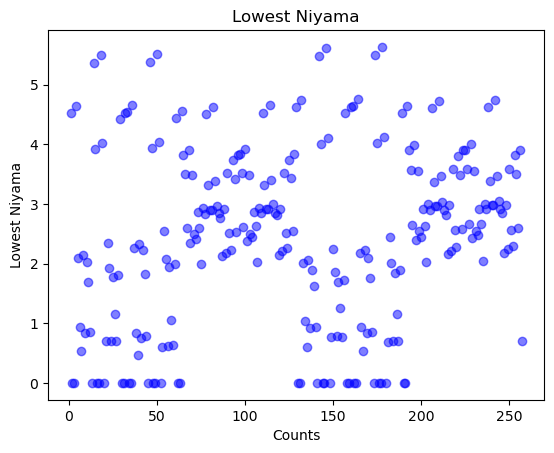

In [58]:
counts = range(1,len(Fractional_Factorial_doe_center_pt)+1)

plt.scatter(counts,Fractional_Factorial_doe_center_pt['Lowest_Niyama'], alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Counts')
plt.ylabel('Lowest Niyama')
plt.show()

### Regression Model

In [22]:
formula5 = 'Lowest_Niyama ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient_left) + C(heat_transfer_coefficient_right)'

model5 = sm.OLS.from_formula(formula5, data=Fractional_Factorial_doe_center_pt).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     38.51
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.56e-49
Time:                        17:19:49   Log-Likelihood:                -328.92
No. Observations:                 257   AIC:                             683.8
Df Residuals:                     244   BIC:                             730.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

The plots of the residuals vs. fitted values are shown below


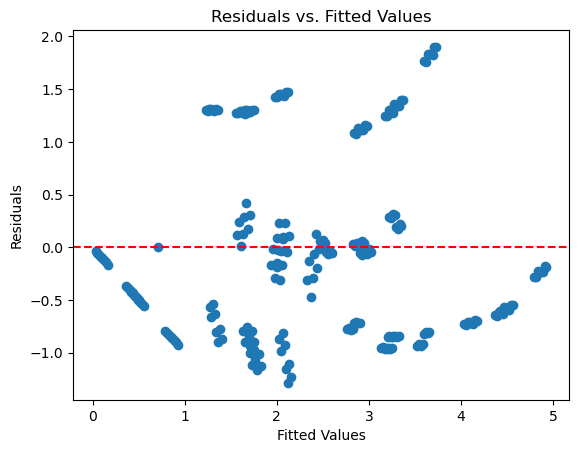

In [23]:
residual5 = model5.resid
Fractional_Factorial_doe_center_pt['Residuals'] =residual5
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model5.fittedvalues, residual5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()



### Normality Test

In [25]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residual5)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')
    

Shapiro-Wilk Test Statistic: 0.8820956796067643
p-value: 3.1964828702241334e-13
The residuals are not normally distributed (reject H0).


#### Anova

In [26]:
from statsmodels.formula.api import ols

formula7 = 'Lowest_Niyama ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient_left) + C(heat_transfer_coefficient_right)'

model7 = ols(formula7, data=Fractional_Factorial_doe_center_pt).fit()

anova_results7 = sm.stats.anova_lm(model7, typ=2)

print(anova_results7)

                                        sum_sq     df          F        PR(>F)
C(rho_l)                             10.662995    2.0   6.685438  1.490432e-03
C(rho_s)                              7.991375    2.0   5.010397  7.370687e-03
C(k_l)                                0.064017    2.0   0.040137  9.606640e-01
C(k_s)                                0.401607    2.0   0.251798  7.776035e-01
C(cp_l)                               0.063500    2.0   0.039813  9.609757e-01
C(cp_s)                               0.085958    2.0   0.053893  9.475445e-01
C(Surr_temp)                         91.456338    2.0  57.340893  3.863861e-21
C(L_fusion)                           0.162840    2.0   0.102097  9.029807e-01
C(temp_init)                          0.085818    2.0   0.053806  9.476275e-01
C(heat_transfer_coefficient_left)   100.555660    2.0  63.045945  8.468205e-23
C(heat_transfer_coefficient_right)  154.981372    2.0  97.169539  9.135151e-32
Residual                            194.584925  244.

In [27]:
if anova_results7['PR(>F)'][0] < 0.05:
    print('The main effects are significant.')
else:
    print('The main effects are not significant.')

The main effects are significant.


/tmp/ipykernel_2509603/3305709261.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results7['PR(>F)'][0] < 0.05:


#### Main effects with center points

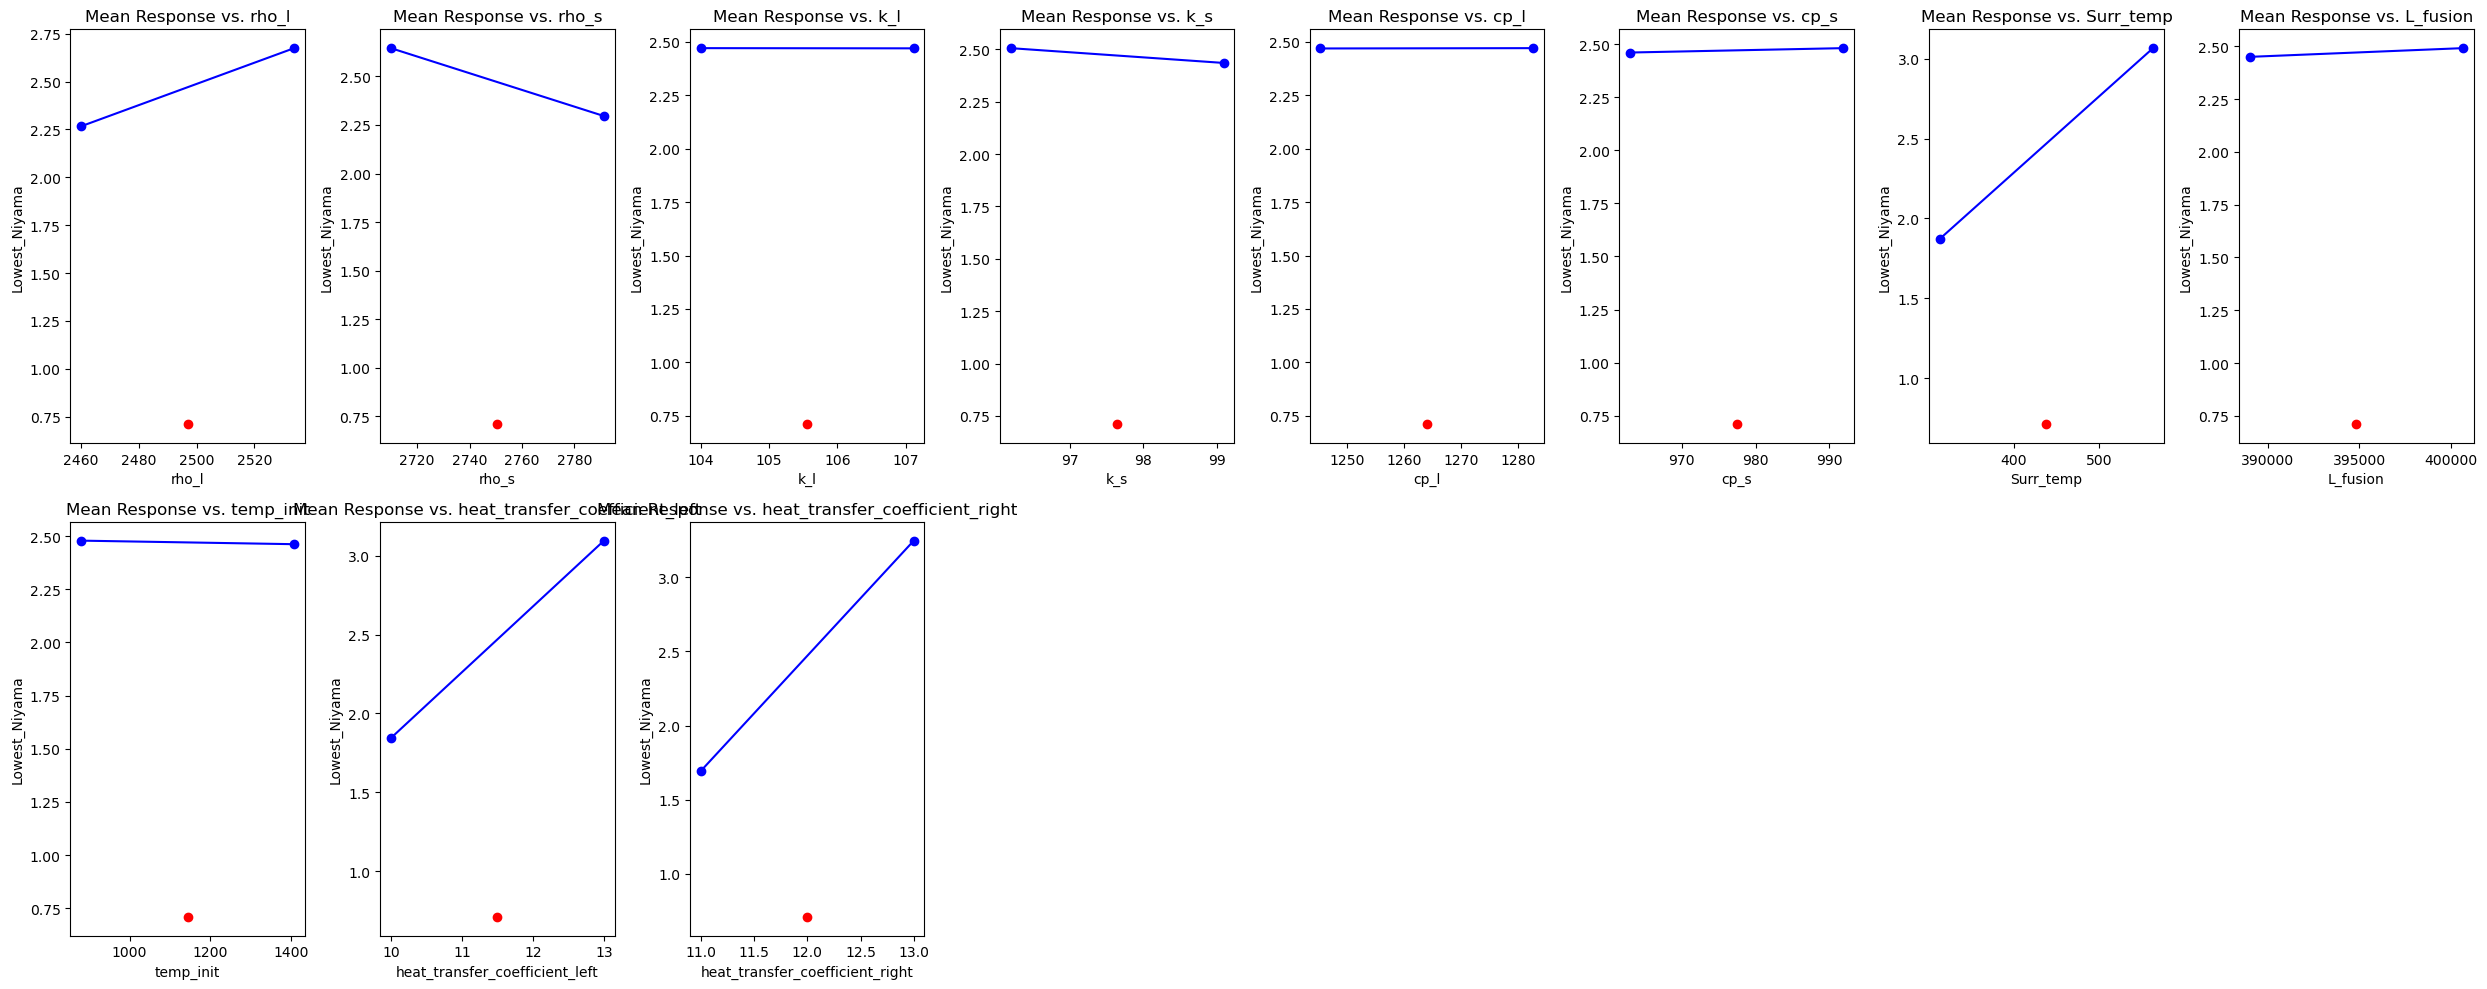

In [63]:
mean_response_center = {}

for factor in factor_names:
    mean_response_center[factor] = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama'].mean()

# print(mean_response_center)
plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 8, i+1)

    mean_responses = mean_response_center[factor]


    center_point = mean_responses.iloc[-2]
    center_point_index = mean_responses.index[-2]
    non_center_points_low = mean_responses.iloc[0]
    non_center_points_low_index = mean_responses.index[0]
    non_center_points_high = mean_responses.iloc[-1]
    non_center_points_high_index = mean_responses.index[-1]

    plt.plot([non_center_points_low_index,non_center_points_high_index], [non_center_points_low,non_center_points_high],marker='o', color='b')
    
    # Plotting the center points
    center_points = mean_response_center[factor]
    plt.scatter([center_point_index], [center_point], color='r', label='Center Points')
    
    # # Plot all individual data points for the factor
    # all_data_points = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama']
    # for key, group in all_data_points:
    #     plt.scatter([key]*len(group), group, alpha=0.3, color='gray')

    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Lowest_Niyama')

plt.tight_layout()
plt.show()


In [38]:
# mean_response_center = {}

# for factor in factor_names:
#     mean_response_center[factor] = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama'].mean()

# plt.figure(figsize=(25, 10))

# for i, factor in enumerate(factor_names):
#     plt.subplot(2, 8, i+1)
#     plt.plot(mean_response_center[factor], marker='o', color='b')
    
#     # Plotting the center points
#     center_points = mean_response_center[factor]
#     plt.scatter(center_points.index, center_points.values, color='r', label='Center Points')
#     plt.title(f'Mean Response vs. {factor}')
#     plt.xlabel(factor)
#     plt.ylabel('Lowest_Niyama')

# plt.tight_layout()
# plt.show()

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site

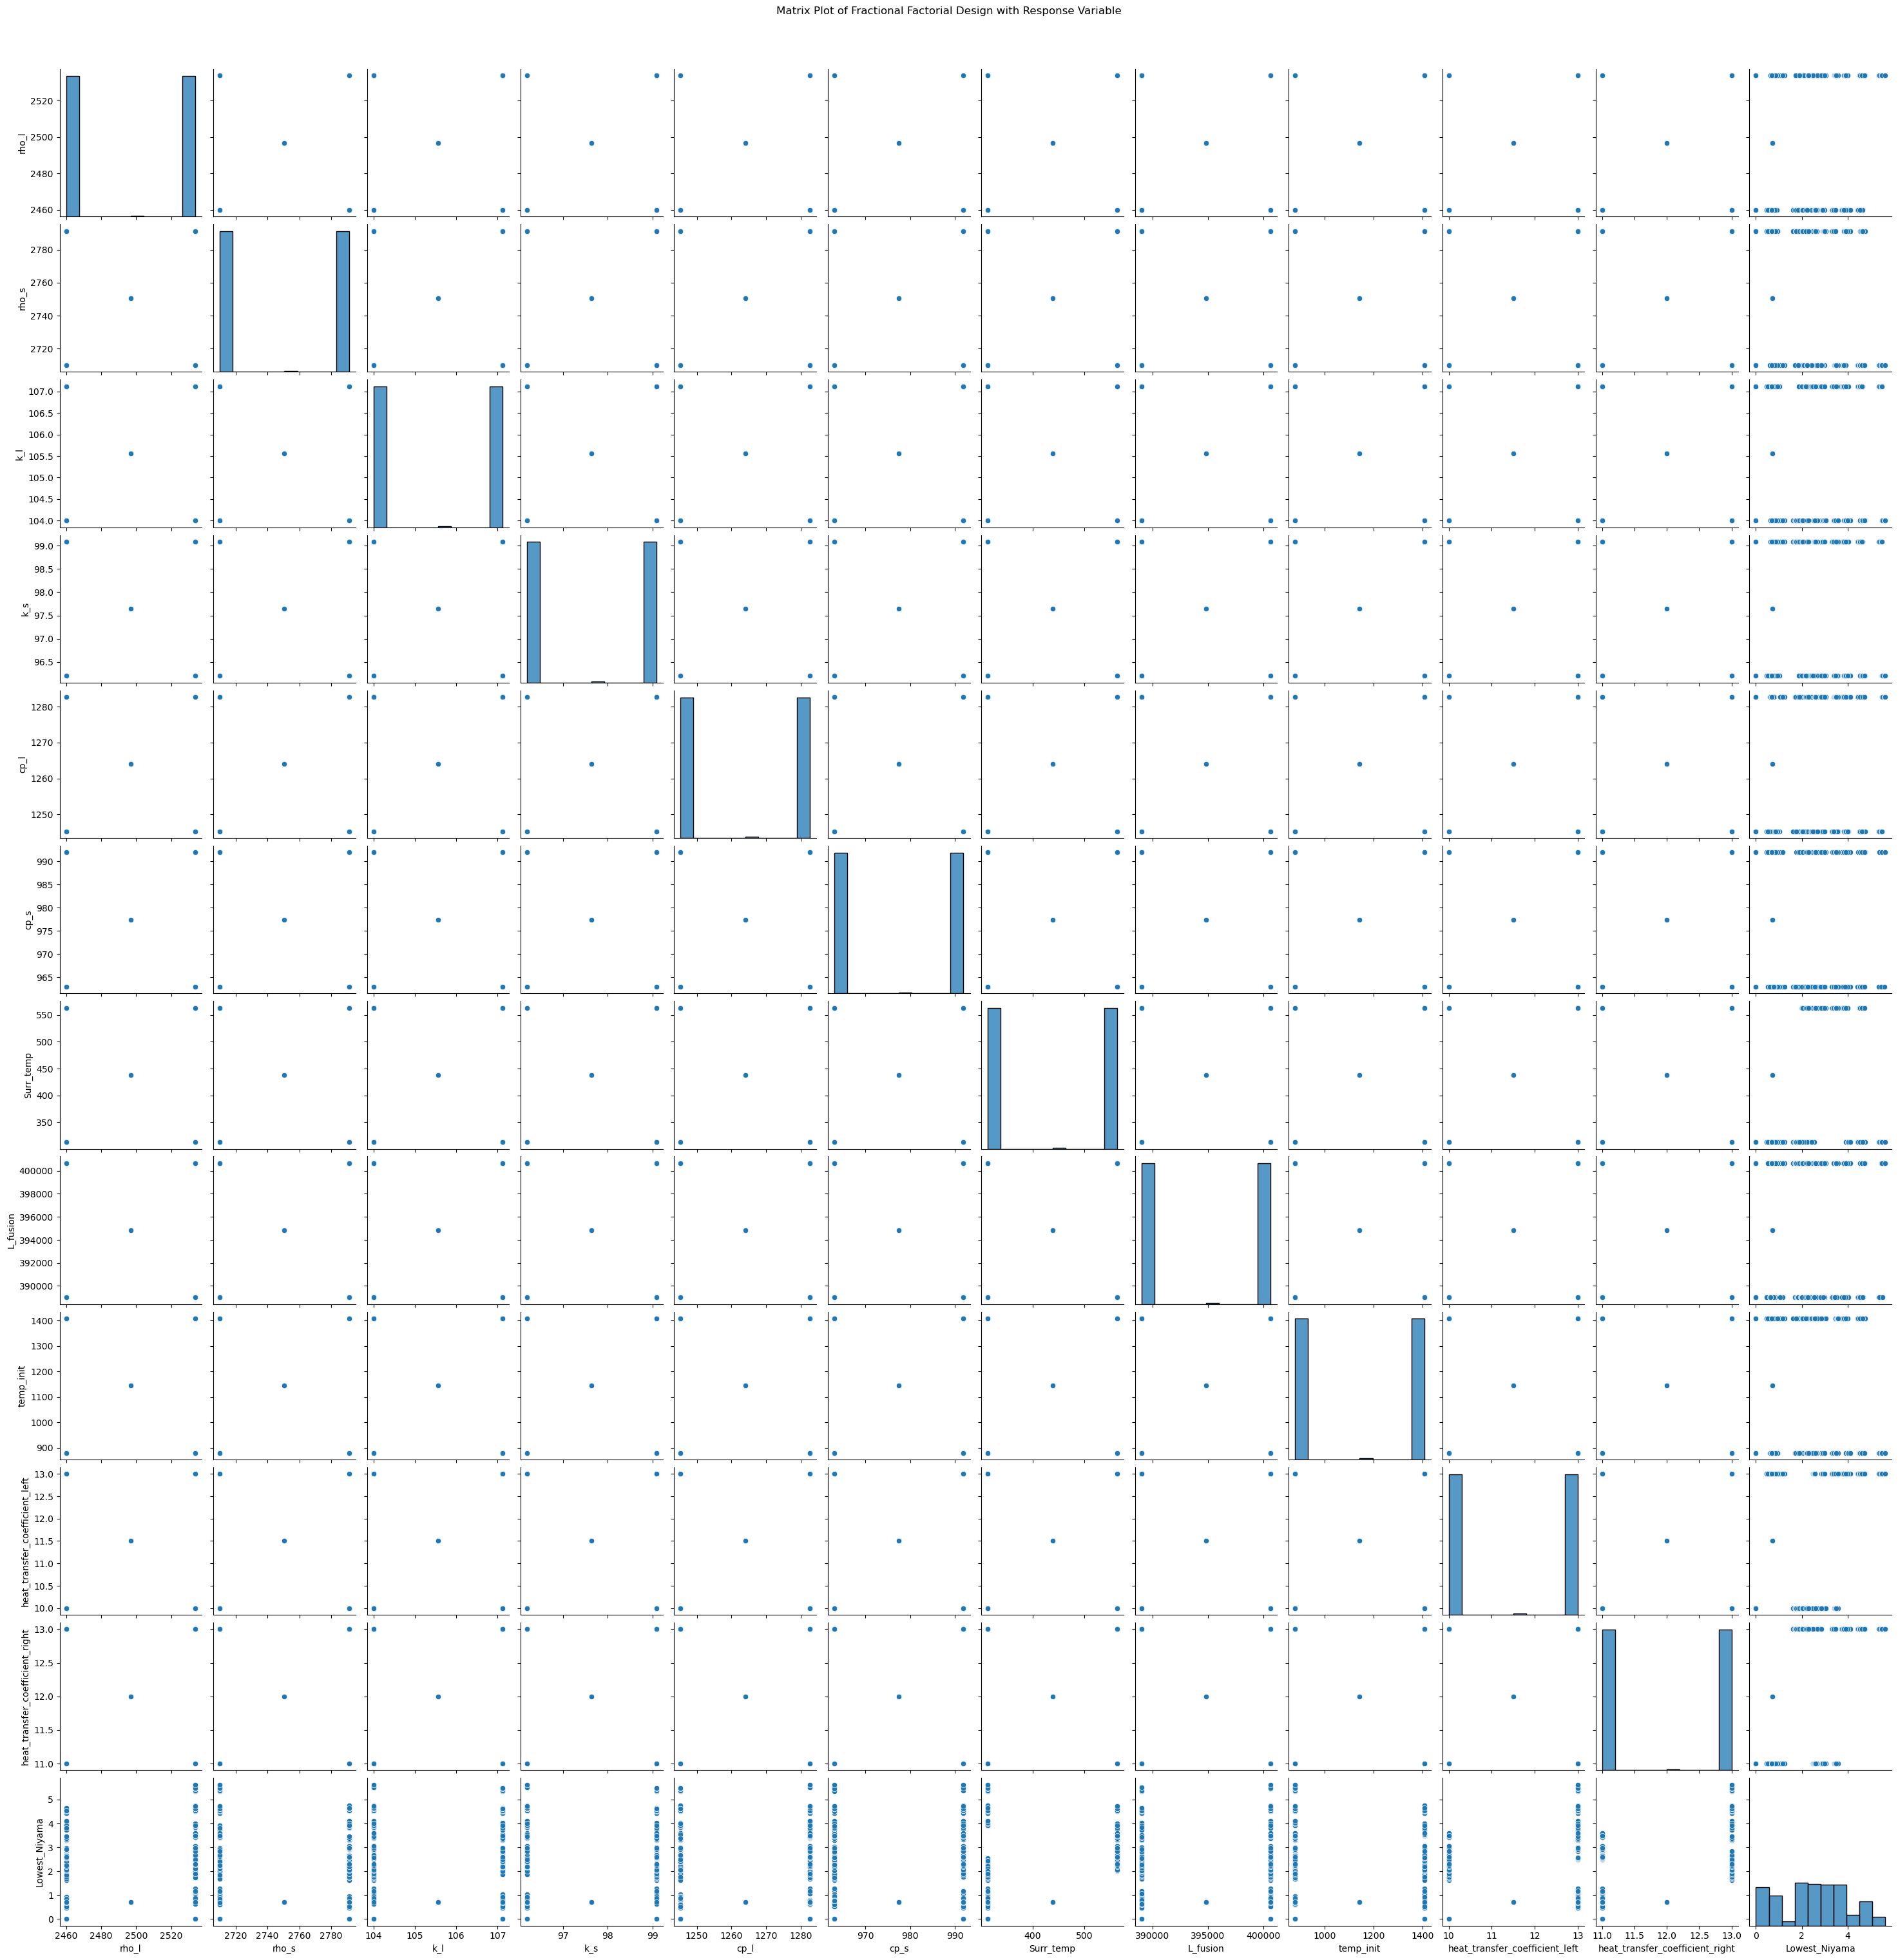

In [49]:
sns.pairplot(Fractional_Factorial_doe_center_pt.iloc[:,:-1],palette='coolwarm', kind='scatter')
plt.suptitle("Matrix Plot of Fractional Factorial Design with Response Variable", y=1.02)
plt.show()